<a href="https://colab.research.google.com/github/KaiSan2001/DeepLearning_StudyLibrary/blob/main/SRUNET/SRUNET_Amended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
'''
Starting Date: 2022.07.04
Ending Date: 2022.07.05
Last Editing Log: 2022.07.09
                  Introduced the original algorithm for computing the PSNR, MSE and SSIM
                  Integrated the 'show_pictures' and 'compare_images' function into the function 'present_pictures'
                  The new function can show the PSNR, MSE, SSIM, and plot the images simultaneously
Coder: Chan Kai San
E-mail: u3556373@connect.hku.hk; zenc2001@gmail.com; kchan52@jh.edu
Description: This programme is designed to establish a pipeline for image super-resolution reconstruction
             The computational kernel is tensorflow's keras library and the Robust U-Net Architecture proposed by Hu. et. al

Reference: X. Hu, M. A. Naiel, A. Wong, M. Lamm and P. Fieguth, "RUNet: A Robust UNet Architecture for Image Super-Resolution," 
           2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2019, pp. 505-507, doi: 10.1109/CVPRW.2019.00073.
             
'''

#Path Initialization#
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deeplearning/SRUNET')
Path = os.getcwd()
print(Path)
#Library Initialization#
import tensorflow as tf         # tensorflow
import tensorflow.keras as K    # keras API
import numpy as np              # numpy to work with tensors (with tf)
import matplotlib.pyplot as plt # function to show images
%matplotlib inline              
import cv2                      # pkg to load image as np.array
from PIL import Image           # Read in the images
import h5py                     # Save the data into h5 file
import random                   # For random sampling
from google.colab.patches import cv2_imshow #Image generation
# vgg net for perceptual loss
from tensorflow.keras.applications.vgg19 import VGG19

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Deeplearning/SRUNET


In [5]:
#Data Pre-cropping#

#GroundTruth Cropping#
os.chdir(Path+'/Cropped/GT')
GTs = sorted(os.listdir(Path+'/Img_Lib/GT'))
nums1 = len(GTs)
for i, name1 in enumerate(GTs):
    fpath1 = Path+'/Img_Lib/GT/' + name1
    image = Image.open(fpath1)
    image = np.array(image)
    image = image[100:612,:]
    image = Image.fromarray(image)

    image.save('%s'%name1)

#Input Cropping#
os.chdir(Path+'/Cropped/Input')
Inputs = sorted(os.listdir(Path+'/Img_Lib/Input'))
nums1 = len(Inputs)
for i, name2 in enumerate(GTs):
    fpath2 = Path+'/Img_Lib/Input/' + name2
    image = Image.open(fpath2)
    image = np.array(image)
    image = image[100:612,:]
    image = Image.fromarray(image)

    image.save('%s'%name2)

(100, 512, 512, 3)
(100, 512, 512, 3)


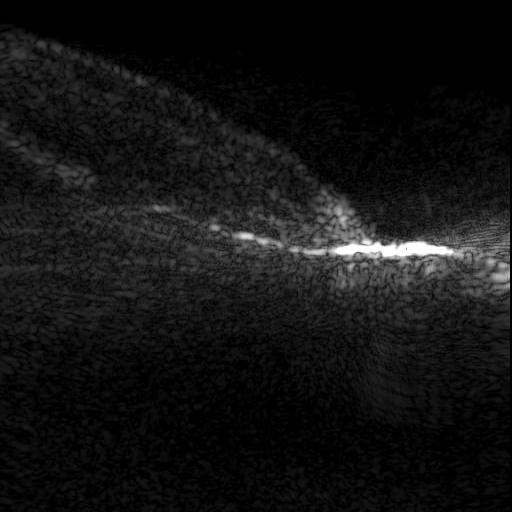

In [6]:
#Cropped-data Processing#
TrainPath = '/content/drive/MyDrive/Deeplearning/SRUNET/Cropped'
Input_set = []
GT_set =[]

#Dimension Augmentation#
def img_aug (img_1):
  image_aug = np.zeros((512,512,3), dtype = float) 
  image_aug[:,:511,:]=img_1[:,:,:]
  return image_aug

#Reading#
GTs = sorted(os.listdir(TrainPath+'/GT'))
for gt in GTs:
    #find the GT image
    fpath1 = TrainPath + '/GT/' + gt #Read in the file one by one
    gt_img = cv2.imread(fpath1)
    #print(gt_img.shape)

    #find the corresponding Input image
    fpath2 = TrainPath +'/Input/' + gt
    Input_img = cv2.imread(fpath2)

    #Storage
    gt_img = img_aug (gt_img)
    Input_img = Input_img = img_aug(Input_img)

    GT_set.append(gt_img)
    Input_set.append(Input_img)
    
GT_set = np.array(GT_set, dtype=np.float32)
Input_set = np.array(Input_set, dtype=np.float32)

print(GT_set.shape)
print(Input_set.shape)
cv2_imshow(GT_set[1]) #Check the Image quality

In [7]:
#Random Selection and Storage in h5#
os.chdir(Path+'/Cropped')
Shuffle_GT_Train = []
Shuffle_GT_Test = []
Shuffle_Input_Train = []
Shuffle_Input_Test = [] #Create two empty lists to store the random samples

#Random Index
Index = random.sample(range(0,100),80)
print(Index)
for i in range(0,100):
  if i in Index:
    #print(i)
    Shuffle_GT_Train.append(GT_set[i])
    Shuffle_Input_Train.append(Input_set[i])
  else:
    Shuffle_GT_Test.append(GT_set[i])
    Shuffle_Input_Test.append(Input_set[i])

Shuffle_GT_Train = np.array(Shuffle_GT_Train, dtype=np.float32)
Shuffle_GT_Test = np.array(Shuffle_GT_Test, dtype=np.float32)
Shuffle_Input_Train = np.array(Shuffle_Input_Train, dtype=np.float32)
Shuffle_Input_Test = np.array(Shuffle_Input_Test, dtype=np.float32)

print(Shuffle_GT_Train.shape)
print(Shuffle_GT_Test.shape)
print(Shuffle_Input_Train.shape)
print(Shuffle_Input_Test.shape)
with h5py.File('Dataset.h5', 'w') as h:
  h.create_dataset('Shuffle_GT_Train', data = Shuffle_GT_Train, shape = Shuffle_GT_Train.shape)
  h.create_dataset('Shuffle_GT_Test', data = Shuffle_GT_Test, shape = Shuffle_GT_Test.shape)
  h.create_dataset('Shuffle_Input_Train', data = Shuffle_Input_Train, shape = Shuffle_Input_Train.shape)
  h.create_dataset('Shuffle_Input_Test', data = Shuffle_Input_Test, shape = Shuffle_Input_Test.shape)

[20, 10, 73, 36, 7, 46, 50, 32, 21, 44, 47, 51, 97, 54, 27, 59, 72, 26, 95, 41, 16, 53, 12, 90, 60, 92, 49, 8, 58, 69, 52, 85, 88, 70, 23, 71, 67, 2, 30, 93, 66, 80, 78, 62, 19, 6, 74, 42, 76, 40, 96, 17, 9, 56, 0, 94, 4, 34, 83, 18, 77, 91, 68, 61, 28, 79, 57, 84, 82, 11, 33, 37, 35, 89, 24, 14, 39, 65, 98, 86]
(80, 512, 512, 3)
(20, 512, 512, 3)
(80, 512, 512, 3)
(20, 512, 512, 3)


In [9]:
print(os.getcwd())
with h5py.File('Dataset.h5', 'r') as h:
    GT_Train = np.array(h.get('Shuffle_GT_Train'))
    GT_Test = np.array(h.get('Shuffle_GT_Test'))
    Input_Train = np.array(h.get('Shuffle_Input_Train'))
    Input_Test = np.array(h.get('Shuffle_Input_Test'))

#Double check to make sure the dimension agreement
print(GT_Train.shape)
print(GT_Test.shape)
print(Input_Train.shape)
print(Input_Test.shape)

/content/drive/MyDrive/Deeplearning/SRUNET/Cropped
(80, 512, 512, 3)
(20, 512, 512, 3)
(80, 512, 512, 3)
(20, 512, 512, 3)


In [11]:
#Normalize the image#
def Img_Normalization(image_array):
  shape = image_array.shape
  post_imgArray = np.zeros((shape[0],shape[1],shape[2],3),dtype = np.float32)
  for i in range(shape[0]):
    image_array[i,:,:,0] = image_array[i,:,:,0].astype(np.float32) /255
    post_imgArray[i,:,:,0] = image_array[i,:,:,1]
    post_imgArray[i,:,:,1] = image_array[i,:,:,1]
    post_imgArray[i,:,:,2] = image_array[i,:,:,1]

  return post_imgArray

# Perceptual loss function# 
# load pre-trained (imagenet) vgg network, excluding fully-connected layer on the top
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = K.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
# make the net not trainable
for l in vgg_layer.layers: l.trainable=False 

print(vgg_layer.summary())

def perceptual_loss(y_true,y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

# defining other metrics:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

#Define Signal-to-Noise Ratio (PSNR)#
def PSNR(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

#Define Mean Squared Error#
def MSE(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

#Define Structural Similarity#
from skimage.metrics import structural_similarity as SSIM
def compare_images(target, ref):
    scores = []
    scores.append(PSNR(target, ref))
    scores.append(MSE(target, ref))
    scores.append(SSIM(target, ref, multichannel=True))
    return scores

# defining image_proc_net
def image_proc_net(training_mode=True):
    """
    Function which creates the model to preprocess images.
    2 different types of model with different layers depending
    on whether it is in training mode or in testing mode
    """
    inputs = K.layers.Input((None, None, 3))
    if training_mode:
        # training mode: downsampling, gaussian noise and upsamplin
        x = K.layers.UpSampling2D((2,2))(inputs)
    else:
        # testing mode: just an upsampling
        x = K.layers.UpSampling2D((2,2))(inputs)

    model = K.models.Model(inputs, x)

    for l in model.layers: l.trainable=False

    return model

# instantiating the two models (for train and test)
image_proc_train = image_proc_net(training_mode=True)
image_proc_test = image_proc_net(training_mode=False)

#training_mode
print(image_proc_train.summary())
print('\n')
#testing_mode
print(image_proc_test.summary())

#Image Preprocess function
def image_preprocess(image, training_mode=True):
    """
    Function which preprocess automatically an image
    wether it's in training or testing mode

    input: 
      - image: np array (image tensor)
      - training_mode: binary flag
    """
    image = np.expand_dims(image,axis=0)
    if training_mode:
        return tf.squeeze(image_proc_train(image))
    else:
        return tf.squeeze(image_proc_test(image))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [12]:
#Model Setup#
# defining the image input and our batch size
input_size = 512 # 128x128x3 images (training_set) 需要是16的倍数。。。
batch_size= 4 

#Model Definition
def train_generator():
    global batch_size
    while True:
        for start in range(0, x_train_shape[0], batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, x_train_shape[0])
                    for i in range(start,end):
                      img_x = x_train[i]
                      img_y = y_train[i]
                      x_batch.append(img_x)
                      y_batch.append(img_y)
                    
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch
                    
def valid_generator():
    global batch_size
    while True:
        for start in range(0, x_test_shape[0], batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, x_test_shape[0])
                    for i in range(start,end):
                      img_x = x_test[i]
                      img_y = y_test[i]
                      x_batch.append(img_x)
                      y_batch.append(img_y)
                    
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch


def test_generator():
    global batch_size
    while True:
        for start in range(0, x_test_shape[0], batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, x_test_shape[0])
                    for i in range(start,end):
                      img_x = x_test[i]
                      img_y = y_test[i]
                      x_batch.append(img_x)
                      y_batch.append(img_y)
                    
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

# pixel shuffle 
def pixel_shuffle(scale):
    '''
    This function implements pixel shuffling.
    ATTENTION: the scale should be bigger than 2, otherwise just returns the input.
    '''
    if scale > 1:
        return lambda x: tf.nn.depth_to_space(x, scale)
    else:
        return lambda x:x

#blocks definition for upscaling/downscaling
def add_down_block(x_inp, filters, kernel_size=(3, 3), padding="same", strides=1,r=False):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    if r:
        # if r=True then we import an (1X1) Conv2D after input layer 
        # in order the dimensions of 2 tensors coincide.
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x

def add_up_block(x_inp,skip,filters, kernel_size=(3, 3), padding="same", strides=1,upscale_factor=2):
    x = pixel_shuffle(scale=upscale_factor)(x_inp)
    x = K.layers.Concatenate()([x, skip])
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Activation('relu')(x)
    return x

def add_bottleneck(x_inp,filters, kernel_size=(3, 3), padding="same", strides=1):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.Activation('relu')(x)
    return x

def RUNet():
    """
      Implementing with Keras the Robust UNet Architecture as proposed by
      Xiaodan Hu, Mohamed A. Naiel, Alexander Wong, Mark Lamm, Paul Fieguth
      in "RUNet: A Robust UNet Architecture for Image Super-Resolution"
    """
    global input_size
    inputs = K.layers.Input((input_size,input_size, 3))
    
    
    down_1 = K.layers.Conv2D(64,(7,7), padding="same", strides=1)(inputs)
    down_1 = K.layers.BatchNormalization()(down_1)
    down_1 = K.layers.Activation('relu')(down_1)
    
    down_2 = K.layers.MaxPool2D(pool_size=(2,2))(down_1)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,128,r=True)
    
    down_3 = K.layers.MaxPool2D(pool_size=(2, 2),strides=2)(down_2)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,256,r=True)
    
    down_4 = K.layers.MaxPool2D(pool_size=(2, 2))(down_3)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,512,r=True) 
    
    down_5 = K.layers.MaxPool2D(pool_size=(2, 2))(down_4)
    down_5 = add_down_block(down_5,512)
    down_5 = add_down_block(down_5,512)
    down_5 = K.layers.BatchNormalization()(down_5)
    down_5 = K.layers.Activation('relu')(down_5)
    
    
    bn_1 = add_bottleneck(down_5, 1024)
    bn_2 = add_bottleneck(bn_1, 512)
    
    up_1 = add_up_block(bn_2,down_5, 512,upscale_factor=1)
    up_2 = add_up_block(up_1,down_4, 384,upscale_factor=2)
    up_3 = add_up_block(up_2,down_3, 256,upscale_factor=2)
    up_4 = add_up_block(up_3,down_2, 96,upscale_factor=2) 
    
    up_5 = pixel_shuffle(scale=2)(up_4)
    up_5 = K.layers.Concatenate()([up_5,down_1])
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
   
    outputs = K.layers.Conv2D(3,(1,1), padding="same")(up_5)
    model = K.models.Model(inputs, outputs)
    return model

model = RUNet()
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  9472        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [13]:
#Train and Test Data Interfacing#
x_train = Img_Normalization(Input_Train)
y_train = Img_Normalization(GT_Train)
x_test = Img_Normalization(Input_Test)
y_test = Img_Normalization(GT_Test)

#Data Dimension Agreement
x_train_shape = x_train.shape
y_train_shape = y_train.shape
x_test_shape = x_test.shape
y_test_shape = y_test.shape
print(x_train_shape)
print(y_train_shape)
print(x_test_shape)
print(y_test_shape)

(80, 512, 512, 3)
(80, 512, 512, 3)
(20, 512, 512, 3)
(20, 512, 512, 3)


In [14]:
#Model Training#
opt=K.optimizers.Adam(learning_rate=0.0001) # Adam optimizer, Initially 0.001
model.compile(optimizer=opt,loss=perceptual_loss,metrics=[psnr,ssim,K.losses.mean_squared_error])
history = model.fit_generator(generator=train_generator(),
                              steps_per_epoch=np.ceil(float(x_train_shape[0]) / float(batch_size)),
                              epochs=20,
                              verbose=1,
                              validation_data=valid_generator(),
                              shuffle=True,
                              validation_steps=np.ceil(float(x_test_shape[0]) / float(batch_size)))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


20/20 [==============================] - 69s 2s/step - loss: 33720.0391 - psnr: -31.3295 - ssim: 0.0012 - mean_squared_error: 1422.0475 - val_loss: 63003.5625 - val_psnr: -31.4419 - val_ssim: 0.0226 - val_mean_squared_error: 1521.8749
Epoch 2/20
20/20 [==============================] - 29s 1s/step - loss: 22965.6484 - psnr: -30.4677 - ssim: 0.0133 - mean_squared_error: 1171.5493 - val_loss: 45586.9688 - val_psnr: -27.6484 - val_ssim: 0.0423 - val_mean_squared_error: 627.2137
Epoch 3/20
20/20 [==============================] - 30s 1s/step - loss: 17836.4648 - psnr: -27.7740 - ssim: 0.0448 - mean_squared_error: 660.1642 - val_loss: 25058.3945 - val_psnr: -24.3070 - val_ssim: 0.0675 - val_mean_squared_error: 305.5161
Epoch 4/20
20/20 [==============================] - 30s 2s/step - loss: 14668.4316 - psnr: -24.2572 - ssim: 0.0766 - mean_squared_error: 294.9554 - val_loss: 14555.4873 - val_psnr: -24.3776 - val_ssim: 0.0667 - val_mean_squared_error: 281.8763
Epoch 5/20
20/20 [==============

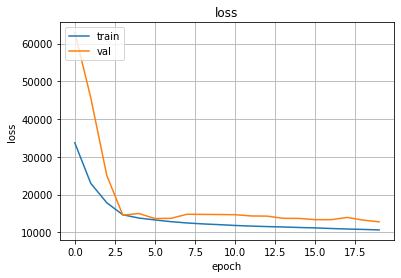

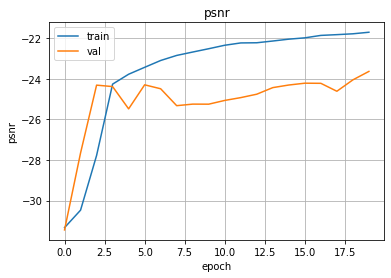

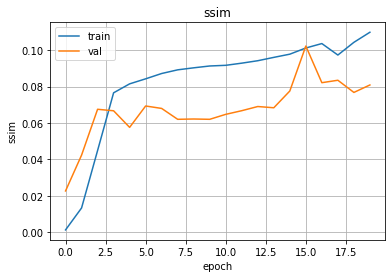

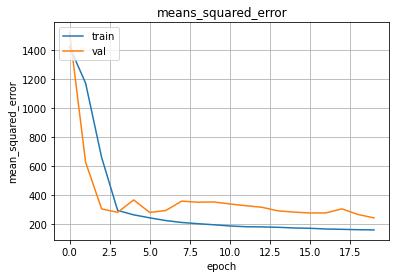

In [15]:
def history_results(history, par1='loss', par2='val_loss', title='loss'):
    """
    Plot the history of the the 2 metrics (par1, par2) during 
    the training (epochs)
    """
    plt.plot(history.history[par1])
    plt.plot(history.history[par2])
    plt.title(title)
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    return

history_results(history)
history_results(history, 'psnr', 'val_psnr', 'psnr')
history_results(history, 'ssim', 'val_ssim', 'ssim')
history_results(history, 'mean_squared_error', 'val_mean_squared_error', 'means_squared_error')

In [26]:
def present_pictures(img_idx, x_batch, y_batch):
    """
    Function which shows 3 images:
    - Ground truth: High Resolution image
    - Low Resolution image
    - Super Resolution image using our trained model
    """
    #Predicted, Input, and GroundTruth Image Screening
    pre = model(np.expand_dims(x_batch[img_idx],axis=0))
    pre = np.squeeze(pre)
    inputx = x_batch[img_idx]
    GTy = y_batch[img_idx]

    #ImageSaving
    cv2.imwrite(Path+'/Valid/Output/Output%s.jpg'%img_idx, pre)
    cv2.imwrite(Path+'/Valid/Input/Input%s.jpg'%img_idx, inputx)
    cv2.imwrite(Path+'/Valid/GT/GT%s.jpg'%img_idx, GTy)

    #ImageReading
    Prez_Input = cv2.imread(Path+'/Valid/Input/Input%s.jpg'%img_idx)
    Prez_Ground_Truth = cv2.imread(Path+'/Valid/GT/GT%s.jpg'%img_idx)
    Prez_Predicted = cv2.imread(Path+'/Valid/Output/Output%s.jpg'%img_idx)

    #Plotting for better visualization
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))

    ax[0].imshow(Prez_Input)
    ax[0].title.set_text("Input Image")

    ax[1].imshow(Prez_Predicted)
    ax[1].title.set_text("Predicted Image")

    ax[2].imshow(Prez_Ground_Truth)
    ax[2].title.set_text("GroundTruth Image")


    #Input V.S. Ground_Truth#
    metrics = compare_images(Prez_Input, Prez_Ground_Truth)
    print("Metrics for Input and Ground_Truth image")
    print("PSNR: {}".format(metrics[0]))
    print("MSE: {}".format(metrics[1]))
    print("SSIM: {}".format(metrics[2]))
    print('\n')

    #Predicted V.S. Ground_Truth#
    metrics = compare_images(Prez_Predicted, Prez_Ground_Truth)
    print("Metrics for Predicted and Ground_Truth image")
    print("PSNR: {}".format(metrics[0]))
    print("MSE: {}".format(metrics[1]))
    print("SSIM: {}".format(metrics[2]))
    print('\n')

    return

In [22]:
# trying to visualize the results with some training images
chunk_size=15

x_chunk = []
y_chunk = []

#Randomly select chunk_size amount of data from the test data set
Idx = random.sample(range(0,x_test_shape[0]),chunk_size)
for i in Idx:
  img_y = y_test[i]
  img_x = x_test[i]
  x_chunk.append(img_x)
  y_chunk.append(img_y)
x_chunk = np.array(x_chunk)
y_chunk = np.array(y_chunk)

print(x_chunk.shape);print(y_chunk.shape)

(15, 512, 512, 3)
(15, 512, 512, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Metrics for Input and Ground_Truth image
PSNR: 24.047667789818995
MSE: 768.1302490234375
SSIM: 0.5299840543693963


Metrics for Predicted and Ground_Truth image
PSNR: 25.144516709633894
MSE: 596.691650390625
SSIM: 0.6132214891679503




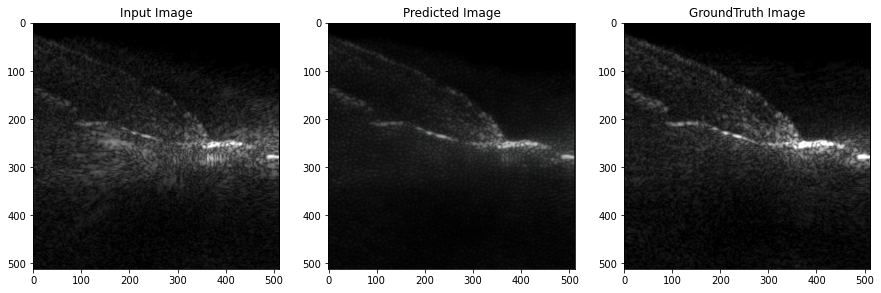

In [32]:
present_pictures(13, x_chunk, y_chunk) #Compare the images for the n_th image in the chunk data set